# Customer Spend Prediction - Using Random Forest Regression
by A4Ayub Data Science Labs (http://www.a4ayub.me/)

### Class Problem Statement

Build a model to predict customer spend based on the hour for shopping

<font color="red">**Please take note that the illustrations in this notebook is NOT for results/accuracy but for explaining the various concepts**</font>

### Data Description

<font color="red">**This data is proprietory and cannot be shared to anyone who is NOT attending A4Ayub Data Science Labs.!**</font>

Each row in the dataset corresponds to one unique product in a basket (e.g. if there are three occurences of the same product in that basket, it will have one row for the product in that basket, with quantity equal to three)

The file has the below structure:

| Column Name | Description | Type | Sample Values |
| --- | --- | --- | --- |
| shop_week | Identifies the week of the basket | Char | Format is YYYYWW where the first 4 characters identify the fiscal year and the other two characters identify the specific week within the year (e.g. 200735). Being the fiscal year, the first week doesn’t start in January.  (See time.csv file for start/end dates of each week) |
| shop_date | Date when shopping has been made. Date is specified in the yyyymmdd format | Char | 20060413, 20060412 |
| shop_weekday | Identifies the day of the week | Num | 1=Sunday, 2=Monday, …, 7=Saturday |
| shop_hour | Hour slot of the shopping | Num | 0=00:00-00:59, 1=01:00-01:59, …23=23:00-23:59 |
| Quantity | Number of items of the same product bought in this basket | Num | Integer number |
| spend | Spend associated to the items bought | Num | Number with two decimal digits |
| prod_code | Product Code | Char | PRD0900001, PRD0900003 |
| prod_code_10 | Product Hierarchy Level 10 Code | Char | CL00072, CL00144 |
| prod_code_20 | Product Hierarchy Level 20 Code | Char | DEP00021, DEP00051 |
| prod_code_30 | Product Hierarchy Level 30 Code | Char | G00007, G00015 |
| prod_code_40 | Product Hierarchy Level 40 Code | Char | D00002, D00003 |
| cust_code | Customer Code | Char | CUST0000001624, CUST0000001912 |
| cust_price_sensitivity | Customer’s Price Sensitivity | Char | LA=Less Affluent, MM=Mid Market, UM=Up Market, XX=unclassified |
| cust_lifestage | Customer’s Lifestage | Char | YA=Young Adults, OA=Older Adults, YF=Young Families, OF=Older Families, PE=Pensioners, OT=Other, XX=unclassified |
| basket_id | Basket ID. All items in a basket share the same basket_id value. | Num | 994100100000020, 994100100000344 |
| basket_size | Basket size | Char | L=Large, M=Medium, S=Small |
| basket_price_sensitivity | Basket price sensitivity  | Char | LA=Less Affluent, MM=Mid Market, UM=Up Market, XX=unclassified |
| basket_type | Basket type | Char | Small Shop, Top Up, Full Shop, XX |
| basket_dominant_mission | Shopping dominant mission | Char | Fresh, Grocery, Mixed, Non Food, XX |
| store_code | Store Code | Char | STORE00001, STORE00002 |
| store_format | Format of the Store | Char | LS, MS, SS, XLS |
| store_region | Region the store belongs to | Char | E02, W01, E01, N03 |

### Workbench

#### Importing the required libraries

In [1]:
# Import the numpy and pandas package
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns

# Import the warnings
import warnings

# Import statsmodels
import statsmodels.formula.api as smf

# Import RMSE
from statsmodels.tools.eval_measures import rmse

# Import Decison Tree Regressor
from sklearn.ensemble import RandomForestRegressor

# Import train test split
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Import the metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# Import Pre-Processing
from sklearn import preprocessing


# configuration settings
%matplotlib inline 
sns.set(color_codes=True)
warnings.filterwarnings('ignore') ## Surpress the warnings
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

#### Load the data into a dataframe

In [2]:
# load the data into a dataframe called supermarket_till_transactions_df
supermarket_till_transactions_df = pd.read_csv("../data/beginner/supermarket_till_transactions.csv")

In [3]:
# view the top five records
supermarket_till_transactions_df.head(5)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200607,20060413,5,20,1,103,PRD0900097,CL00001,DEP00001,G00001,...,LA,YF,994100100532898,L,LA,Top Up,Fresh,STORE00001,LS,E02
1,200607,20060412,4,19,1,28,PRD0900353,CL00070,DEP00020,G00007,...,LA,YF,994100100532897,M,MM,Small Shop,Fresh,STORE00001,LS,E02
2,200607,20060413,5,20,3,84,PRD0900550,CL00167,DEP00055,G00016,...,LA,YF,994100100532898,L,LA,Top Up,Fresh,STORE00001,LS,E02
3,200607,20060412,4,19,1,221,PRD0901647,CL00010,DEP00003,G00002,...,LA,YF,994100100532897,M,MM,Small Shop,Fresh,STORE00001,LS,E02
4,200607,20060413,5,20,1,334,PRD0902064,CL00073,DEP00021,G00007,...,LA,YF,994100100532898,L,LA,Top Up,Fresh,STORE00001,LS,E02


In order to illustrate Support Vector Regression we just need two variables which are:
1. SHOP_HOUR
2. SPEND

In [5]:
supermarket_till_transactions_df = supermarket_till_transactions_df[["SHOP_HOUR","SPEND"]]
supermarket_till_transactions_df.head(5)

,SHOP_HOUR,SPEND
0,20,103
1,19,28
2,20,84
3,19,221
4,20,334


In [6]:
# Divide the dataset into training and testing sets
X, X_test, y, y_test = train_test_split(supermarket_till_transactions_df.iloc[:,0:-1],
                                        supermarket_till_transactions_df.iloc[:,-1],
                                        test_size=0.33,
                                        random_state=42)

In [10]:
regressor = RandomForestRegressor(n_estimators =10, random_state = 0)
regressor.fit(X,y)
regressor.fit(X_test,y_test) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [9]:
print("R-Squared on train dataset={}".format(regressor.score(X_test,y_test)))

R-Squared on train dataset=-0.14843337914907617


In [11]:
print("R-Squared on test dataset={}".format(regressor.score(X_test,y_test)))

R-Squared on test dataset=0.14861177163240935


**Visualizing the Random Forest Results**

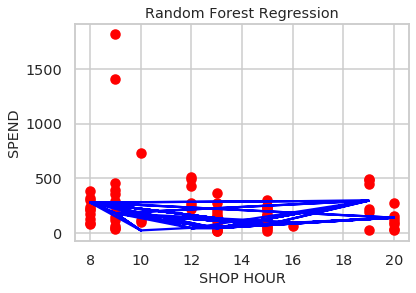

In [14]:
#X_grid = np.arange(min(X),max(X),0.01)
#X_grid = X_grid.reshape(len(X_grid),1)
plt.scatter(X,y,color='red')
plt.plot(X,regressor.predict(X),color='blue')
plt.title('Random Forest Regression')
plt.xlabel('SHOP HOUR')
plt.ylabel('SPEND')
plt.show()